In [1]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

### Book  Dataset
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset


In [2]:
rating_df = pd.read_csv('Ratings.csv')

rating_df.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [3]:
book_df = pd.read_csv('Books.csv')

#book_df.drop(['Image-URL-S', 'Image-URL-M','Image-URL-L'], axis=1,inplace=True)

C:\Users\cseka\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
book_df.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
book_df.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,202,16807,271044,271044,271041
top,0944256007,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/042515601X.0...,http://images.amazon.com/images/P/067082982X.0...,http://images.amazon.com/images/P/014023313X.0...
freq,1,27,632,13903,7535,2,2,2


### EDA on Rating dataset
- This dataset contain user rating information which will be very handy for recommendation system

In [6]:
rating_df.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [7]:
rating_df = rating_df.merge(book_df,on='ISBN')

<AxesSubplot:>

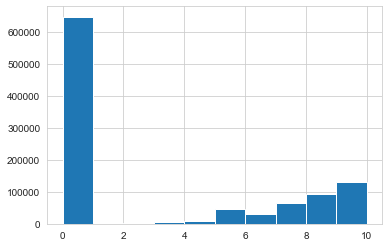

In [8]:
rating_df['Book-Rating'].hist()

### Also as we are considering book rating , we will consider rating given by avid book readers.So lets put some threshold on rating count given by users

In [9]:
x = rating_df.groupby('User-ID').count()['Book-Rating'] > 150
userIndex = x[x].index
nm_rating_df=rating_df[rating_df['User-ID'].isin(userIndex)]

In [10]:
y = nm_rating_df.groupby('Book-Title').count()['Book-Rating']>=50
books = y[y].index

In [11]:
final_ratings = nm_rating_df[nm_rating_df['Book-Title'].isin(books)]


### User Dataset

In [12]:
users_df = pd.read_csv('Users.csv')

users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


# Popularity Based recommendation

### Avarage rating

In [13]:
avg_rating_df = final_ratings.groupby('Book-Title').mean()['Book-Rating'].reset_index()
avg_rating_df.rename(columns={'Book-Rating':'avg_rating'},inplace=True)
avg_rating_df.sort_values('avg_rating', ascending=[False]).head(10)

,Book-Title,avg_rating
276,Harry Potter and the Sorcerer's Stone (Book 1),5.166667
698,The Little Prince,4.981818
4,84 Charing Cross Road,4.963636
275,Harry Potter and the Prisoner of Azkaban (Book 3),4.641026
273,Harry Potter and the Goblet of Fire (Book 4),4.566434
274,Harry Potter and the Order of the Phoenix (Boo...,4.333333
750,The Secret Garden,4.176471
114,Carrie,4.150000
272,Harry Potter and the Chamber of Secrets (Book 2),4.060302
206,Ender's Game (Ender Wiggins Saga (Paperback)),4.000000


### Total rating count

In [14]:
total_rating_df = final_ratings.groupby('Book-Title').count()['Book-Rating'].reset_index()
total_rating_df.rename(columns={'Book-Rating':'num_ratings'},inplace=True)
total_rating_df.sort_values('num_ratings', ascending=[False]).head(10)

,Book-Title,num_ratings
853,Wild Animus,421
704,The Lovely Bones: A Novel,317
106,Bridget Jones's Diary,296
627,The Da Vinci Code,265
717,The Pelican Brief,263
711,The Nanny Diaries: A Novel,261
714,The Notebook,261
650,The Firm,257
181,Divine Secrets of the Ya-Ya Sisterhood: A Novel,257
22,A Painted House,255


In [15]:
popular_books_list = total_rating_df.merge(avg_rating_df,on='Book-Title')
popular_books_list.sort_values(['avg_rating','num_ratings'], ascending=[False,False]).head(10)

,Book-Title,num_ratings,avg_rating
276,Harry Potter and the Sorcerer's Stone (Book 1),96,5.166667
698,The Little Prince,55,4.981818
4,84 Charing Cross Road,55,4.963636
275,Harry Potter and the Prisoner of Azkaban (Book 3),156,4.641026
273,Harry Potter and the Goblet of Fire (Book 4),143,4.566434
274,Harry Potter and the Order of the Phoenix (Boo...,126,4.333333
750,The Secret Garden,85,4.176471
114,Carrie,60,4.150000
272,Harry Potter and the Chamber of Secrets (Book 2),199,4.060302
206,Ender's Game (Ender Wiggins Saga (Paperback)),75,4.000000


### Plot the simple mean against the number of reviews 

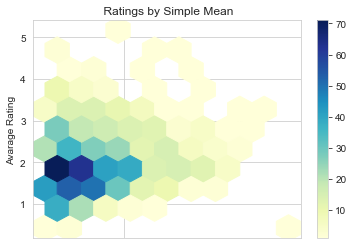

In [16]:
grid   = pd.DataFrame({
                    'Avarage Rating': popular_books_list['avg_rating'],
                    'Number of Reviewers': popular_books_list['num_ratings']
                 })
grid.plot(x='Number of Reviewers', y='Avarage Rating', kind='hexbin',
                  xscale='log', cmap='YlGnBu', gridsize=10, mincnt=1,
                  title=" Ratings by Simple Mean")
plt.show()


This figure shows that the average rating of a books is actually slightly Lesser than 3

 ### Bayesian Adjustment Rating
 https://www.analyticsvidhya.com/blog/2019/07/introduction-online-rating-systems-bayesian-adjusted-rating/

In [17]:
bayes_adj_df=popular_books_list
bayes_adj_df['total']=bayes_adj_df['num_ratings']*bayes_adj_df['avg_rating']

In [18]:
total=bayes_adj_df['total'].sum()
total_views=bayes_adj_df['num_ratings'].sum()

In [19]:
bayes_adj_df['bayes_rating']=((bayes_adj_df['num_ratings']*bayes_adj_df['avg_rating'])+total)/((bayes_adj_df['num_ratings']+total_views))

In [20]:
bayes_adj_df.sort_values(['bayes_rating'], ascending=[False]).head(10)

,Book-Title,num_ratings,avg_rating,total,bayes_rating
275,Harry Potter and the Prisoner of Azkaban (Book 3),156,4.641026,724.0,2.070412
272,Harry Potter and the Chamber of Secrets (Book 2),199,4.060302,808.0,2.070345
704,The Lovely Bones: A Novel,317,3.242902,1028.0,2.070023
273,Harry Potter and the Goblet of Fire (Book 4),143,4.566434,653.0,2.069826
802,To Kill a Mockingbird,208,3.615385,752.0,2.069355
276,Harry Potter and the Sorcerer's Stone (Book 1),96,5.166667,496.0,2.069033
274,Harry Potter and the Order of the Phoenix (Boo...,126,4.333333,546.0,2.068873
627,The Da Vinci Code,265,3.143396,833.0,2.068865
277,Harry Potter and the Sorcerer's Stone (Harry P...,198,3.308081,655.0,2.068343
751,The Secret Life of Bees,234,3.029915,709.0,2.068072


# Colaborative Filtering

### Prepare dataset

In [21]:
final_ratings.head(1)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
63,278418,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...


In [22]:
final_ratings=final_ratings.sort_values(by=['User-ID','Book-Rating'], ascending=[False,False]) 
final_ratings.shape

(75201, 10)

In [23]:
test_df=final_ratings.groupby('User-ID').head(10)
test_df.shape

(10795, 10)

In [24]:
final_ratings=final_ratings[~final_ratings.isin(test_df).all(1)]
final_ratings.shape

(64406, 10)

### Matrix factorisation

In [25]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
book_features_df = final_ratings.pivot_table(
    index='Book-Title',
    columns='User-ID',
    values='Book-Rating'
).fillna(0)
# convert dataframe of movie features to scipy sparse matrix

In [26]:
book_features_df

User-ID,254,1733,1903,2033,2110,2276,2766,2891,2977,3363,...,274301,274308,274808,275970,276680,277427,277478,277639,278188,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Apply nearest neighbour Algorithms

In [27]:
from scipy.sparse import csr_matrix

book_features_df_matrix = csr_matrix(book_features_df.values)

from sklearn.neighbors import NearestNeighbors


model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(book_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [28]:
book_df[book_df['Book-Title']=='1984'].head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2104,0451524934,1984,George Orwell,1990,Signet Book,http://images.amazon.com/images/P/0451524934.0...,http://images.amazon.com/images/P/0451524934.0...,http://images.amazon.com/images/P/0451524934.0...


In [29]:
query_index = book_features_df.index.get_loc('1984')
#print(query_index)

distances, indices = model.kneighbors(book_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 9)
indices=list(indices.flatten())

indices.remove(query_index)
indices

[218, 662, 861, 736, 696, 728, 493, 673]

In [30]:

book_df[(book_df['Book-Title'].isin(book_features_df.index[indices]))].groupby('Book-Title').head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
162,0671461494,The Hitchhiker's Guide to the Galaxy,Douglas Adams,1982,Pocket,http://images.amazon.com/images/P/0671461494.0...,http://images.amazon.com/images/P/0671461494.0...,http://images.amazon.com/images/P/0671461494.0...
179,3257208626,Fahrenheit 451,Ray Bradbury,1994,Distribooks Inc,http://images.amazon.com/images/P/3257208626.0...,http://images.amazon.com/images/P/3257208626.0...,http://images.amazon.com/images/P/3257208626.0...
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...
915,0440219078,The Giver (21st Century Reference),LOIS LOWRY,1994,Laure Leaf,http://images.amazon.com/images/P/0440219078.0...,http://images.amazon.com/images/P/0440219078.0...,http://images.amazon.com/images/P/0440219078.0...
1029,0345348036,The Princess Bride: S Morgenstern's Classic Ta...,WILLIAM GOLDMAN,1987,Del Rey,http://images.amazon.com/images/P/0345348036.0...,http://images.amazon.com/images/P/0345348036.0...,http://images.amazon.com/images/P/0345348036.0...
1051,0671510053,SHIPPING NEWS,Annie Proulx,1994,Scribner,http://images.amazon.com/images/P/0671510053.0...,http://images.amazon.com/images/P/0671510053.0...,http://images.amazon.com/images/P/0671510053.0...
4187,0142002267,"Word Freak: Heartbreak, Triumph, Genius, and O...",Stefan Fatsis,2002,Penguin Books,http://images.amazon.com/images/P/0142002267.0...,http://images.amazon.com/images/P/0142002267.0...,http://images.amazon.com/images/P/0142002267.0...
10091,0140179836,The Liar's Club: A Memoir,Mary Karr,1998,Penguin USA (Paper),http://images.amazon.com/images/P/0140179836.0...,http://images.amazon.com/images/P/0140179836.0...,http://images.amazon.com/images/P/0140179836.0...


In [31]:
bayes_adj_df[(bayes_adj_df['Book-Title'].isin(book_features_df.index[indices]))].groupby('Book-Title').head(1)

,Book-Title,num_ratings,avg_rating,total,bayes_rating
218,Fahrenheit 451,132,3.113636,411.0,2.066916
493,SHIPPING NEWS,124,1.959677,243.0,2.064905
662,The Giver (21st Century Reference),58,2.448276,142.0,2.065374
673,The Hitchhiker's Guide to the Galaxy,96,3.166667,304.0,2.066483
696,The Liar's Club: A Memoir,53,2.132075,113.0,2.065126
728,The Princess Bride: S Morgenstern's Classic Ta...,57,2.754386,157.0,2.065601
736,The Red Tent (Bestselling Backlist),194,3.056701,593.0,2.067630
861,"Word Freak: Heartbreak, Triumph, Genius, and O...",52,3.692308,192.0,2.066203


### Few things to Note:
- While we collaborating filtering does gives similar rating , But at the end success rate of any recommendation always depend on what an users really want.
- Some user may like to explore a books of similar auther or publisher
- So we can prepare our top-n list by combining different results from different filtering like -popularity based , collaborative filtering, contant based filtering 

### Like with the result we got we can add few other top rated books of the same author

In [32]:
data_pop_df=  pd.merge(book_df, bayes_adj_df,how='left', left_on=["Book-Title"], right_on =["Book-Title"]) 

In [33]:
res=data_pop_df[data_pop_df['Book-Author']=='George Orwell'].sort_values('avg_rating', ascending=[False]).groupby('Book-Title').head(1)
res.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,num_ratings,avg_rating,total,bayes_rating
269379,0582060184,1984,George Orwell,1991,Longman Publishing Group,http://images.amazon.com/images/P/0582060184.0...,http://images.amazon.com/images/P/0582060184.0...,http://images.amazon.com/images/P/0582060184.0...,85.0,3.411765,290.0,2.066599
209114,1854597892,Animal Farm,George Orwell,2004,Nick Hern Books,http://images.amazon.com/images/P/1854597892.0...,http://images.amazon.com/images/P/1854597892.0...,http://images.amazon.com/images/P/1854597892.0...,76.0,2.881579,219.0,2.065903
4182,0452254264,Nineteen Eighty-Four,George Orwell,1983,New Amer Library (Mm),http://images.amazon.com/images/P/0452254264.0...,http://images.amazon.com/images/P/0452254264.0...,http://images.amazon.com/images/P/0452254264.0...,NaN,NaN,NaN,NaN


## Evaluation metrics

In [34]:
userlist=list(final_ratings['User-ID'].unique())[:200]

In [35]:
final_ratings=final_ratings[final_ratings['User-ID'].isin(userlist)]
test_df=test_df[test_df['User-ID'].isin(userlist)]

In [36]:
final_ratings.head(1)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
750,278418,055356451X,0,Night Sins,TAMI HOAG,1995,Bantam,http://images.amazon.com/images/P/055356451X.0...,http://images.amazon.com/images/P/055356451X.0...,http://images.amazon.com/images/P/055356451X.0...


In [37]:
test_df.head(1)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
109508,278418,0515130389,8,Carolina Moon,Nora Roberts,2001,Jove Books,http://images.amazon.com/images/P/0515130389.0...,http://images.amazon.com/images/P/0515130389.0...,http://images.amazon.com/images/P/0515130389.0...


In [38]:
result=final_ratings.sort_values(by=['User-ID','Book-Rating'],ascending=[True,False])
result=result.groupby('User-ID').head(15)

In [39]:
top_n = 10
k = 50
top_n = 10

recommend_dict = { }
for index, row in result.iterrows():
    user=row['User-ID']
    if user not in recommend_dict.keys():
        recommend_dict[user]={}
        
    book_title=row['Book-Title'] 
    query_index = book_features_df.index.get_loc(book_title)
    distances, indices = model.kneighbors(book_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors =5)
    indices=list(indices.flatten())
    res=book_df[(book_df['Book-Title'].isin(book_features_df.index[indices]))].groupby('Book-Title').head(1)
    
    indexes=list(res['Book-Title'])


    
    for ids in indexes:
        if(ids==book_title):
            continue
        if(~((result['Book-Title'] == ids) & (result['User-ID'] ==user)).any()):
            if ids not in recommend_dict[user].keys():
                recommend_dict[user][ids] =1
            else:
                recommend_dict[user][ids]+=1
                    
        
    
        
        

In [40]:
# Iterating over values
recommendations=[]
for userid, books in recommend_dict.items():
    total=0
    mlist=[]
    for i in books:
        total+=1
        mlist.append(i)
        if(total>15):
            break
    recommendations.append([userid,mlist])

In [41]:
recommendations=pd.DataFrame(recommendations,columns=['user_id','books'])
recommendations.head(2) 

,user_id,books
0,227447,"[Tell Me Lies (Tell Me Lies), Sudden Prey, Bla..."
1,227520,"[Stanislaski Sisters, Sacred Sins, I'll Take M..."


## Hit rate

In [42]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.books)[0]
    total+=1
    for rs in results:
        
        if(test_df[(test_df['Book-Title'] == rs) & (test_df['User-ID'] ==i) ].any().any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.345


## Hit rate on most liked items

In [43]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.books)[0]
    total+=1
    for rs in results:
        
        if(test_df[(test_df['Book-Title'] == rs) & (test_df['User-ID'] ==i) &( test_df['Book-Rating'] >8) ].any().any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.215


### Calculate MAP@K

In [44]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.books)[0]
    
    for rs in results:
        total+=1
        if(test_df[(test_df['Book-Title'] == rs) & (test_df['User-ID'] ==i) ].any().any()):
                hit+=1
               
        
hit_ratio=hit/total   
print(hit_ratio)

0.033121019108280254
